## Course: DSC530
## Assignment: 10.2, Time Series Analysis
## Name: Laura Hoffmann
## Date: 11/6/2020

### Setup

In [1]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot
import statsmodels.formula.api as smf

#### Needed Functions from Chapter 12

In [2]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

dailies = GroupByQualityAndDay(transactions)

def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='red')
    
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

def SimulateResults(daily, iters=101, func=RunLinearModel):
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq
    
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

# 12-1
The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in "Nonlinear Relationships" on page 133.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of RunLinearModel that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [3]:
import warnings; warnings.simplefilter('ignore')

def RunQuadraticModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

name = 'high'
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Fri, 06 Nov 2020   Prob (F-statistic):          4.57e-164
Time:                        15:55:26   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### With these results we can see R-Squared is about .45 which means that the explanatory variables years and years2 account for 45% of the variability in price per gram. 

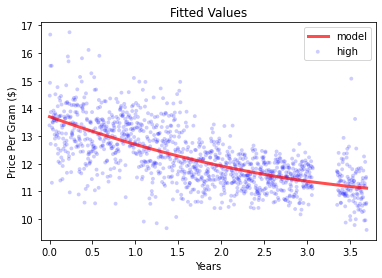

In [4]:
PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted Values', xlabel='Years', xlim=[-0.1, 3.8], ylabel='Price Per Gram ($)')

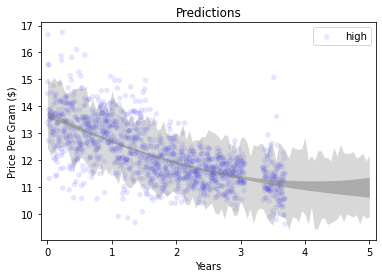

In [5]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title='Predictions', xlabel='Years', xlim=[-.1,5.1], ylabel='Price Per Gram ($)')

### The dark grey area is the 90% confidence interval for the sampling error while the light grey is the 90% confidence interval for prediction error, (the sum of sampling error and random variation). Using these areas we can see where future predictions should fall.

# 12-2
Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [6]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag
    
def SerialCorr(series, lag=1):
        xs = series[lag:]
        ys = series.shift(lag)[lag:]
        corr = thinkstats2.Corr(xs, ys)
        return corr

In [7]:
# Test whether the serial correlation in raw price data is statistically significant

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Serial Correlation:", test.actual)
print("PValue:", pvalue)

Serial Correlation: 0.485229376194738
PValue: 0.0


### We can see here that the serial correlation for raw price data is .48.

In [8]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

import statsmodels.tsa.stattools as smtsa

def FillMissing(daily, span=30):
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = reindexed.ppg.ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)
    
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
    print(name, corr)
    
print(' ')
    
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.resid, lag=1)
    print(name, corr)
    
print(' ')
    
rows = []
print(' '*9, 'High', ' Low', '  Medium')
for lag in [1, 7, 30, 365]:
    print(lag, end='\t')
    for name, filled in filled_dailies.items():            
        corr = SerialCorr(filled.resid, lag)
        print('%.2g' % corr, end='\t')
    print()

high 0.49215941184352774
low 0.11651693646819
medium 0.1884810024122012
 
high -0.005629760489878049
low 0.043895788884764995
medium -0.00843551103110393
 
          High  Low   Medium
1	-0.0056	0.044	-0.0084	
7	0.016	-0.032	-0.045	
30	-0.0075	-0.0082	-0.0051	
365	0.06	0.023	0.016	


### This output presents the serial correlations for raw price data. There are correlations between consecutive days because there are trends in the data. The last output tests for correlations in a day, week, month and year.

In [9]:
# Test for serial correlation in residuals of the linear model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Serial Correlation:", test.actual)
print("PValue:", pvalue)

Test Statistic: 0.11560586074035997
PValue: 0.0


In [10]:
# Test for serial correlation in residuals of the quadratic model

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Serial Correlation:", test.actual)
print("PValue:", pvalue)

Test Statistic: 0.08089524938917429
PValue: 0.009


### We can see that for both linear and quadratic the outputs for serial correlation and pvalues are low and therefore are not necessarily statistically significant. 

## Autocorrelation

I completed this section just to see the visual output for autocorrelation.

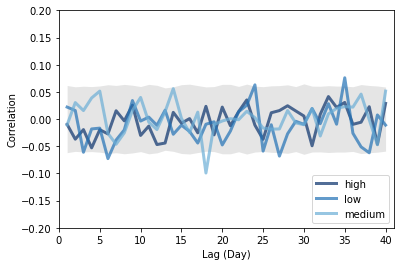

In [11]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags+1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')
    
def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    thinkplot.PrePlot(3)
    daily = dailies['high']
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, unbiased=True)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)
    
axis = [0, 41, -0.2, 0.2]

PlotAutoCorrelation(dailies, add_weekly=False)
thinkplot.Config(axis=axis, loc='lower right', ylabel='Correlation', xlabel='Lag (Day)')